<a href="https://colab.research.google.com/github/DHjeelm/OpenProjectAboutGANs/blob/main/VanillaGANfashion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: Generative Models
## Vanilla GANs

Let us start to learm how to implement GANs, as introduced by [Goodfellow et al.](https://arxiv.org/abs/1406.2661) in Keras, to gain more insights into the training procedure. 

As a simple example, we will use GANs to generate small greyscale images.
We will use the fashion MNIST data set as an alternative to boring MNIST data.

### Software
First we have to import our software. Used versions:
- tf 2.4.0
- tf.keras 2.4.0
- np 1.19.5

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
layers = keras.layers

print("keras version", keras.__version__)
print("numpy version", np.__version__)

keras version 2.8.0
numpy version 1.21.5


Let's now try to grab a GPU. A GPU is not needed but useful as it will heavily accelerate the training.

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found. If you use google colab, request a GPU via "Edit" --> "Notebook Settings"')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Let us download Fashion MNIST and normalitze it to [0,1].

In [3]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), _ = fashion_mnist.load_data()
train_images = train_images[...,np.newaxis] / 255

4431872/4422102 [==============================] - 0s 0us/step


Let's inspect the data!

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


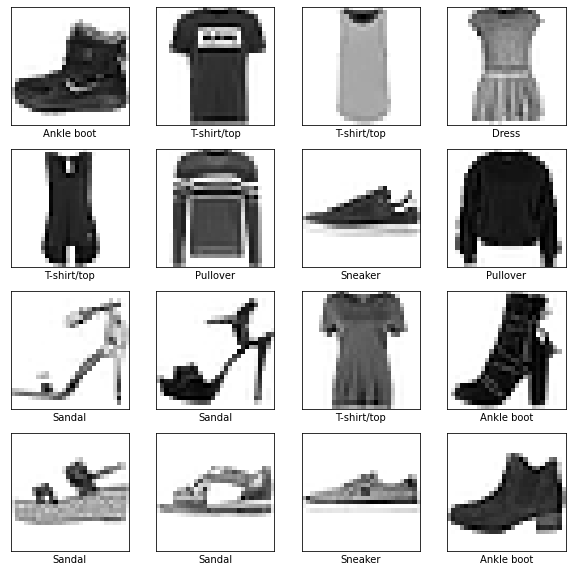

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10,10))

for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow((255 * train_images[i]).astype(np.int).squeeze(), cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])

plt.show()

### Generator
For training GANs we need to further define our generator and discriminator network. We start by defining our generator network, which should map from our noise + label space into the space of images (latent-vector size --> image size). Adding the label the input of to both the generator and discriminator should enforce the generator to produce samples from the according class.

| Task |
|:-------------| 
|Design a meaningful generator model! Remember to check the latent and image dimensions. You can make use of the DCGAN guidelines.
Use a meaningful last activation function!|

In [5]:
def generator_model(latent_size):
    """ Generator network """
    latent = layers.Input(shape=(latent_size,), name="noise")
    z = layers.Dense(14 * 14 * latent_size)(latent)
    z = layers.BatchNormalization()(z)
    z = layers.Reshape([14, 14, latent_size])(z)
    z = layers.Conv2D(128, (5, 5), padding='same')(z)
    z = layers.UpSampling2D(size=(2, 2))(z)
    z = layers.Conv2D(1, (5, 5), padding='same')(z)
    z = layers.Activation('linear')(z)
    return keras.models.Model(latent, z, name="generator")

Build and check the shapes of our generator!

In [6]:
latent_size = 128
g = generator_model(latent_size)
g.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 noise (InputLayer)          [(None, 128)]             0         
                                                                 
 dense (Dense)               (None, 25088)             3236352   
                                                                 
 batch_normalization (BatchN  (None, 25088)            100352    
 ormalization)                                                   
                                                                 
 reshape (Reshape)           (None, 14, 14, 128)       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 up_sampling2d (UpSampling2D  (None, 28, 28, 128)      0         
 )                                                       

We can further plot the model.

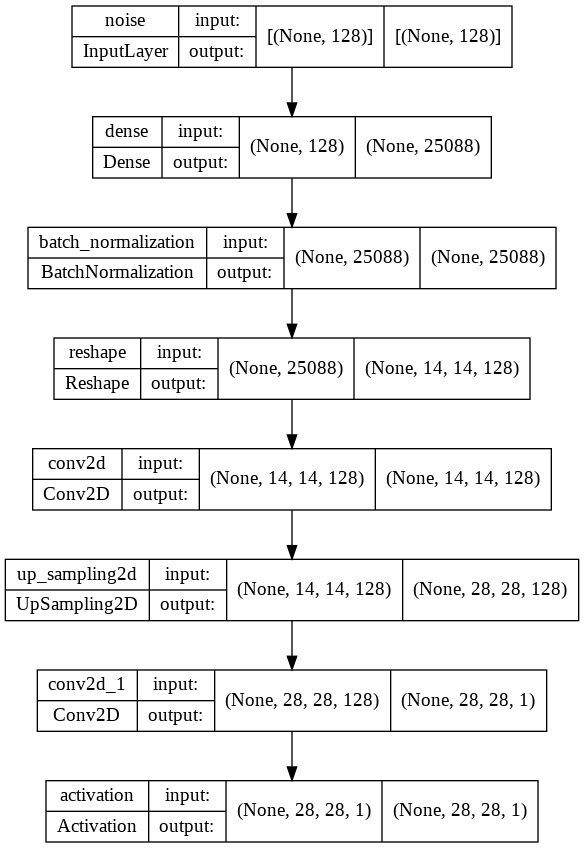

In [7]:
keras.utils.plot_model(g, show_shapes=True)

### Discriminator
The task of the discriminator is to measure the similarity between the fake images (output of the generator) and the real images. So, the network maps from the image space into a 1D space where we can measure the 'distance' between the distributions of the real and generated images (image size --> scalar). Also, here we add the class label to the discriminator.

| Task |
|:-------------| 
|Design a power- and meaningful critic model!
Remember that you can make use of the DCGAN guidelines (use convolutions!) and check the image dimensions.
We need a `softmax` as last activation function in the discriminator!|

In [8]:
def discriminator_model(drop_rate=0.25):
    """ Discriminator network """
    image = layers.Input(shape=(28,28,1), name="images")
    x = layers.Conv2D(32, (5, 5), padding='same', strides=(2, 2))(image)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(drop_rate)(x)
    x = layers.Dense(2)(x)
    x = layers.Activation("softmax")(x)
    return keras.models.Model(image, x, name="discriminator")

In [9]:
d = discriminator_model()
d.summary()
d_opt = keras.optimizers.Adam(lr=2e-4, beta_1=0.5, decay=0.0005)
d.compile(loss='binary_crossentropy', optimizer=d_opt, metrics=["acc"])

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 images (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 32)        832       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 32)        0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dropout (Dropout)           (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 12546     
                                                                 
 activation_1 (Activation)   (None, 2)               

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


We can further plot the model.

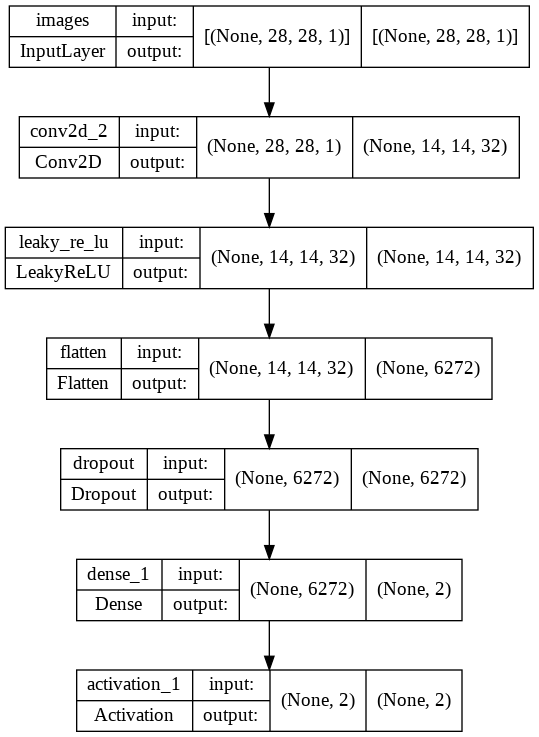

In [10]:
keras.utils.plot_model(d, show_shapes=True)

### Training preparations
After building the generator and discriminator, we have to compile it. But before, we have to freeze the weights of the discriminator. (Remember that we have to fix the discriminator weights for training the generator because we want to fool the discriminator by drawing excellent images, not by making our discriminator a worse classifier).

In [11]:
def make_trainable(model, trainable):
    ''' Freezes/unfreezes the weights in the given model '''
    for layer in model.layers:
        # print(type(layer))
        if type(layer) is layers.BatchNormalization:
            layer.trainable = True
        else:
            layer.trainable = trainable

`Note that after we compiled a model, calling make_trainable will have no effect until compiling the model again.`

In [12]:
make_trainable(d, False)  # freeze the critic during the generator training
make_trainable(g, True)  # unfreeze the generator during the generator training

We build the pipeline for the generator training by stacking the generator on the discriminator (with frozen weights).

In [13]:
gen_input = g.inputs
generator_training = keras.models.Model(gen_input, d(g(gen_input)))
generator_training.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 noise (InputLayer)          [(None, 128)]             0         
                                                                 
 generator (Functional)      (None, 28, 28, 1)         3749633   
                                                                 
 discriminator (Functional)  (None, 2)                 13378     
                                                                 
Total params: 3,763,011
Trainable params: 3,699,457
Non-trainable params: 63,554
_________________________________________________________________


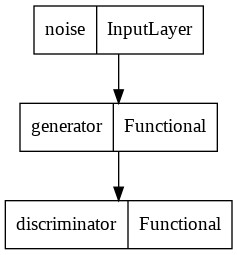

In [14]:
keras.utils.plot_model(generator_training)

In [15]:
g_opt = keras.optimizers.Adam(lr=2e-4, beta_1=0.5, decay=0.0005)
generator_training.compile(loss='binary_crossentropy', optimizer=g_opt)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


We pre-train the discriminator using 5000 real and 5000 fakes samples (pure noise, since the generator wasn't updated yet).

In [16]:
ntrain = 5000
no = np.random.choice(len(train_images), size=ntrain, replace='False')
real_train = train_images[no,:,:,:]   # sample real images from training set
noise_gen = np.random.uniform(0,1,size=[ntrain, latent_size])
generated_images = g.predict(noise_gen)  # generate fake images with untrained generator

X = np.concatenate((real_train, generated_images))
y = np.zeros([2*ntrain, 2])   # class vector: one-hot encoding
y[:ntrain, 1] = 1             # class 1 for real images
y[ntrain:, 0] = 1             # class 0 for generated images

# - Train the discriminator for 1 epoch on this dataset.
d.fit(X,y, epochs=1, batch_size=64)

157/157 [==============================] - 3s 5ms/step - loss: 0.2439 - acc: 0.9941


| Task |
|:-------------| 
|Select a reasonable batch size.
Find a good number of epochs.|

In [ ]:
losses = {"d":[], "g":[]}
discriminator_acc = []
batch_size = 64
nsamples = len(train_images)
iterations_per_epoch = nsamples / batch_size    # number of training steps per epoch len(train_images)
epochs = 10

iters = 0

for epoch in range(epochs):
    print("Epoch: {0:2d}/{1:2d}".format(epoch, epochs))
    perm = np.random.choice(nsamples, size=nsamples, replace='False')

    for i in range(int(iterations_per_epoch)):
        
        # Create a mini-batch of data (X: real images + fake images, y: corresponding class vectors)
        image_batch = train_images[perm[i*batch_size:(i+1)*batch_size],:,:,:]    # real images   
        noise_gen = np.random.uniform(0.,1.,size=[batch_size, latent_size])
        
        # generate images using the generator
        generated_images = g.predict(noise_gen)

        X = np.concatenate((image_batch, generated_images))
        y = np.zeros([2*batch_size,2])  # class vector
        y[0:batch_size,1] = 1
        y[batch_size:,0] = 1
    
        # Train the discriminator on the mini-batch
        d_loss, d_acc  = d.train_on_batch(X,y)
        losses["d"].append(d_loss)
        discriminator_acc.append(d_acc)
    
        # Create a new mini-batch of data (X_: noise, y_: class vectors pretending that these produce real images)
        X_ = np.random.uniform(0.,1.,size=[batch_size, latent_size])
        y_ = np.zeros([batch_size,2])
        y_[:,1] = 1
    
        # Train the generator part of the GAN on the mini-batch
        g_loss = generator_training.train_on_batch(X_, y_)
        losses["g"].append(g_loss)

        iters +=1

        if iters % 500 == 1: 
          # Plot some fake images
          print("iteration", iters)
          print("generator loss", losses["g"][-1])
          print("discriminator loss", losses["d"][-1])
      
          noise = np.random.uniform(0.,1.,size=[16,latent_size])
          generated_images = g.predict(noise)
          plt.figure(figsize=(10,10))
          
          for i in range(16):
              plt.subplot(4,4,i+1)
              plt.xticks([])
              plt.yticks([])
              plt.grid(False)
              img = plt.imshow((255 * generated_images[i]).astype(np.int).squeeze(), cmap=plt.cm.binary)
      
          plt.suptitle("Iteration %i" %iters)
          plt.savefig("./fake_fMNIST_iteration_%.6i.png" % iters)


Epoch:  0/10
iteration 1
generator loss 5.498319625854492
discriminator loss 0.046617429703474045


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


iteration 501
generator loss 0.4702655076980591
discriminator loss 0.50300532579422


### Results
Plot the loss of the discriminator and the generator as function of iterations.

In [ ]:
plt.figure(figsize=(10,8))
plt.semilogy(losses["d"], label='discriminator loss')
plt.semilogy(losses["g"], label='generator loss')
plt.ylabel("loss")
plt.xlabel("iterations")
plt.legend()
plt.show()

Plot the accuracy of the discriminator as function of iterations

In [ ]:
plt.figure(figsize=(10,8))
plt.semilogy(discriminator_acc, label='discriminator')
plt.ylabel("accuracy")
plt.xlabel("iterations")
plt.legend()
plt.show()

| Task |
|:-------------| 
|Check the loss and the generated images.
Does the image quality correlate with the discriminator or the generator loss?
Is the generator able to produce all classes of the dataset?
How can you improve the performance?|

To nicely see the training progress, we can create a gif of the generated samples during the training.

In [ ]:
import imageio
import glob

out_file = 'generated_fMNIST_samples.gif'

with imageio.get_writer(out_file, mode='I', duration=0.5) as writer:
    file_names = glob.glob('fake_fMNIST_iteration*.png')
    file_names = sorted(file_names)
    last = -1

    for i, file_name in enumerate(file_names):
        animated_image = imageio.imread(file_name)
        writer.append_data(animated_image)

    animated_image = imageio.imread(file_name)
    writer.append_data(animated_image)

from IPython.display import Image
Image(open('generated_fMNIST_samples.gif','rb').read())

[link text](https://)